# Experiment

Dataset: Shanghai Telecom dataset discretize on 30 minute inverval. No filter and spatial aggregation

## Requirements

- Pre-processed dataset located at `{ROOT}/data/sh30-cinf`
- Pre-computed 100 clusters located at `{ROOT}/data/exploratory_analysis/mog_100.npy`

## Import and constants

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import tqdm
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from src.path import ROOT

# trajectory length
SEQ_LENGTH: int = 48

# cuda flag
USE_CUDA: bool = True

if USE_CUDA and not torch.cuda.is_available():
    USE_CUDA = False
    print('fallback to cpu as CUDA is not available on this device')

## Define dataset

### define path

Change the path variable here if you place your dataset files in a different location.

In [8]:
cluster_path = f'{ROOT}/exploratory_analysis/mog_100.npy'
dataset_path = str(ROOT.joinpath('data/sh30-cinf'))

### split dataset

Split to pre-defined training set and test set

In [9]:
import os
from datetime import date

from src.data_preprocess.trajectory import from_dataframe
from src.ml.dataset import get_shanghai_date

file_list = os.listdir(dataset_path)

def is_test(fname: str):
    '''
    returns True if file belongs to test set
    '''
    fdate = get_shanghai_date(fname)
    ref_date = date(2014, 6, 18)
    return fdate >= ref_date and (fdate - ref_date).days < 15


test_files = [fname for fname in file_list if is_test(fname)]
train_files = [fname for fname in file_list if not is_test(fname)]

### read basestations

In [10]:
all_candidates: np.ndarray = np.load(cluster_path)

### load dataset

Load dataset files into in-memory.

In [23]:
from src.data_preprocess.trajectory import from_dataframe, Trajectory

def read_csv(fname: str):
    # https://stackoverflow.com/questions/36909368/precision-lost-while-using-read-csv-in-pandas#:~:text=Pandas%20uses%20a%20dedicated%20decimal-to-binary%20converter%20that%20sacrifices,of%20speed.%20Passing%20float_precision%3D%27round_trip%27%20to%20read_csv%20fixes%20this.
    df = pd.read_csv(f'{dataset_path}/{fname}', float_precision='round_trip')
    return from_dataframe(df, SEQ_LENGTH)

test_trajectories: list[dict[str, Trajectory]] = [None] * len(test_files)

for i in tqdm.trange(len(test_files)):
    fname = test_files[i]
    test_trajectories[i] = read_csv(fname)

100%|██████████| 15/15 [00:43<00:00,  2.91s/it]


Optional: remove stationary users

In [24]:
min_unique_loc_count = 3

for i in range(len(test_trajectories)):
    test_trajectories[i] = {
        uid: trajectory
        for uid, trajectory in test_trajectories[i].items()
        if len(set(trajectory.points)) >= min_unique_loc_count
    }

Optional: remove non-persistent users

In [25]:
from src.utils import set_intersect

persistent_users = set_intersect(*(trajectories.keys() for trajectories in test_trajectories))

for i in range(len(test_trajectories)):
    test_trajectories[i] = {
        uid: trajectory
        for uid, trajectory in test_trajectories[i].items()
        if uid in persistent_users
    }

len(persistent_users)

193

## baseline

#### define metric

In [13]:
from src.main.baseline import RecoveryFromAshDistance

ref_lat = np.median(all_candidates[:, 0]).item()
ref_long = np.median(all_candidates[:, 1]).item()

day_timestamp = 12

distance_metric = RecoveryFromAshDistance(ref=(ref_lat, ref_long), day_time=day_timestamp)

#### night time trajectory recovery

In [26]:
from src.main.baseline import DailyTrajectoryRecovery, get_aggregated_observations

predicted: list[list[Trajectory]] = [None] * len(test_trajectories)

for i in tqdm.trange(0, len(test_trajectories), desc='night time recovery'):
    trajectories = [Trajectory(t.points[:day_timestamp]) for t in test_trajectories[i].values()]

    algorithm = DailyTrajectoryRecovery(
        get_observations=lambda t: get_aggregated_observations(trajectories, t),
        cost_matrix=distance_metric.compute,
        sequence_length=day_timestamp,
        sequence_count=len(trajectories)
    )

    algorithm.run(verbose=False)
    predicted[i] = algorithm.get_predicted_trajectories()

night time recovery: 100%|██████████| 15/15 [00:00<00:00, 95.70it/s]


Evaluate

In [27]:
from src.eval.metrics import greedy_match, similarity, mean_distance

avg_accuracy: float = 0
avg_recovery_error: float = 0

for predicted_trajectories, target_trajectories in tqdm.tqdm(zip(predicted, test_trajectories), total=len(predicted)):
    target_trajectories = [Trajectory(t.points[:day_timestamp]) for t in target_trajectories.values()]
    
    indices = greedy_match(predicted_trajectories, target_trajectories)
    n_trajectories = len(predicted_trajectories)

    accuracy = similarity(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean()

    recovery_error = mean_distance(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean() / 1000

    avg_accuracy += accuracy / len(test_trajectories)
    avg_recovery_error += recovery_error / len(test_trajectories)

print(f'average accuracy: {avg_accuracy}')
print(f'average recovery error: {avg_recovery_error}')

100%|██████████| 15/15 [00:00<00:00, 91.49it/s]

average accuracy: 0.9475532527346
average recovery error: 0.6129726359511535


#### single day trajectory recovery (night time + day time)

In [28]:
predicted: list[list[Trajectory]] = [None] * len(test_trajectories)

for i in tqdm.trange(0, len(test_trajectories), desc='night + day recovery'):
    trajectories = [Trajectory(t.points) for t in test_trajectories[i].values()]

    algorithm = DailyTrajectoryRecovery(
        get_observations=lambda t: get_aggregated_observations(trajectories, t),
        cost_matrix=distance_metric.compute,
        sequence_length=SEQ_LENGTH,
        sequence_count=len(trajectories)
    )

    algorithm.run(verbose=False)
    predicted[i] = algorithm.get_predicted_trajectories()

night + day recovery: 100%|██████████| 15/15 [00:00<00:00, 17.92it/s]


Evaluate

In [29]:
avg_accuracy: float = 0
avg_recovery_error: float = 0

for predicted_trajectories, target_trajectories in tqdm.tqdm(zip(predicted, test_trajectories), total=len(predicted)):
    target_trajectories = [*target_trajectories.values()]
    
    indices = greedy_match(predicted_trajectories, target_trajectories)
    n_trajectories = len(predicted_trajectories)

    accuracy = similarity(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean()

    recovery_error = mean_distance(
        np.array(predicted_trajectories),
        np.array(target_trajectories)[indices]
    ).mean() / 1000

    avg_accuracy += accuracy / len(test_trajectories)
    avg_recovery_error += recovery_error / len(test_trajectories)

print(f'average accuracy: {avg_accuracy}')
print(f'average recovery error: {avg_recovery_error}')

100%|██████████| 15/15 [00:00<00:00, 46.93it/s]

average accuracy: 0.34737334484743815
average recovery error: 12.89772005364775


### cross-day trajectory recovery

In [30]:
from src.utils import set_intersect

persistent_users = set_intersect(*(trajectories.keys() for trajectories in test_trajectories))

persistent_trajectories: list[dict[str, Trajectory]] = [None] * len(test_trajectories)

for i in range(len(test_trajectories)):
    persistent_trajectories[i] = {
        uid: trajectory
        for uid, trajectory in test_trajectories[i].items()
        if uid in persistent_users
    }

len(persistent_users)

193

single day trajectory recovery

In [31]:
predicted: list[list[Trajectory]] = [None] * len(persistent_trajectories)

for i in tqdm.trange(0, len(persistent_trajectories), desc='night + day recovery'):
    trajectories = [Trajectory(t.points) for t in persistent_trajectories[i].values()]

    algorithm = DailyTrajectoryRecovery(
        get_observations=lambda t: get_aggregated_observations(trajectories, t),
        cost_matrix=distance_metric.compute,
        sequence_length=SEQ_LENGTH,
        sequence_count=len(trajectories)
    )

    algorithm.run(verbose=False)
    predicted[i] = algorithm.get_predicted_trajectories()

night + day recovery: 100%|██████████| 15/15 [00:00<00:00, 19.95it/s]


cross-day recovery

In [32]:
from src.main.baseline import CrossDayTrajectoryRecovery

algorithm = CrossDayTrajectoryRecovery(predicted)
algorithm.run()

predicted_trajectories = algorithm.result

cross-day recovery: 100%|██████████| 14/14 [01:13<00:00,  5.27s/it]


Evaluate

average accuracy: 0.2283606793321819
average recovery error: 14.761468536360374


Text(0.5, 0, 'recovery error (km)')

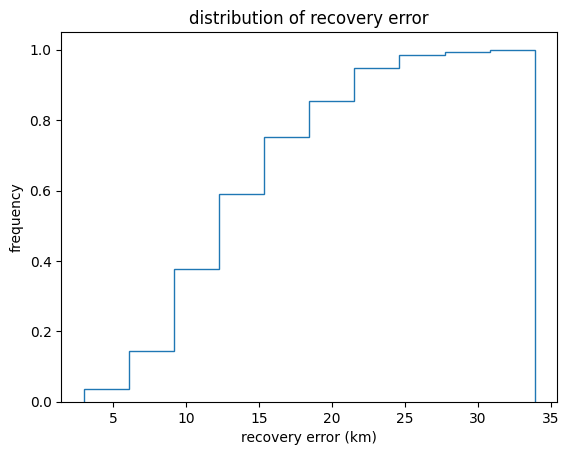

In [33]:
import copy
from src.eval.metrics import similarity, mean_distance

# merge target trajectories
target_trajectories = copy.deepcopy(persistent_trajectories[0])

for uid, trajectory in target_trajectories.items():
    for i in range(1, len(persistent_trajectories)):
        trajectory.points += persistent_trajectories[i][uid].points

target_trajectories = [*target_trajectories.values()]

indices = greedy_match(predicted_trajectories, target_trajectories)

accuracy = similarity(
    np.array(predicted_trajectories),
    np.array(target_trajectories)[indices]
).mean()

print(f'average accuracy: {accuracy}')

distances = mean_distance(
    np.array(predicted_trajectories),
    np.array(target_trajectories)[indices]
) / 1000

print(f'average recovery error: {distances.mean()}')

plt.title('distribution of recovery error')
plt.hist(distances, cumulative=True, density=True, histtype='step')
plt.ylabel('frequency')
plt.xlabel('recovery error (km)')

[0.0, 0.8497409326424871, 0.9896373056994818, 1.0, 1.0]


Text(0, 0.5, 'unique percentage')

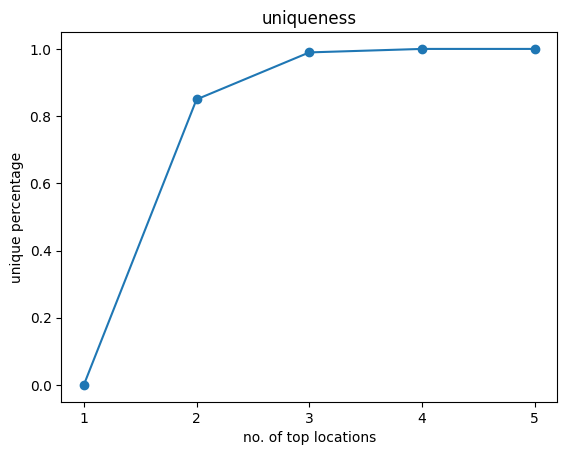

In [34]:
from src.eval.metrics import uniqueness_list

uniqueness = [uniqueness_list(predicted_trajectories, i) for i in range(5)]
print(uniqueness)

plt.plot([str(i + 1) for i in range(5)], uniqueness, marker='o')
plt.title('uniqueness')
plt.xlabel('no. of top locations')
plt.ylabel('unique percentage')

### Result

all persistent users (~1.3k users in total):

| Step | Accuracy (%) | Recovery Error (km) |
|------|----------|----------------|
| 1 | 96 | 0.45 |
| 2 | 48 | 8.9 | 
| 3 | 32 | 11.0 |

<br>

| k | Uniqueness |
|---|------------|
| 1 | 0.0 |
| 2 | 0.42 |
| 3 | 0.95 |
| 4 | 0.99 |
| 5 | 1.0 |

persistent users with >= 3 unique locations per day (193 users in total)
| Step | Accuracy (%) | Recovery Error (km) |
|------|----------|----------------|
| 1 | 95 | 0.61 |
| 2 | 35 | 12.9 | 
| 3 | 23 | 14.8 |

<br>

| k | Uniqueness |
|---|------------|
| 1 | 0.0 |
| 2 | 0.85 |
| 3 | 0.99 |
| 4 | 1.0 |
| 5 | 1.0 |